# Channel & Feature Importances For Hand-crafted features

In this tutorial, we show how to find channel and feature importances, using hand-crafted features on MedNIST data. First, let's download the data

In [1]:
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
# !wget -q https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz

In [3]:
# # unzip the '.tar.gz' file to the current directory
# import tarfile
# datafile = tarfile.open("MedNIST.tar.gz")
# datafile.extractall()
# datafile.close()

I only used 2000 samples per class for faster calculations

In [4]:
data_dir = './MedNIST/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = imread(image_file_list[0]).shape

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 12000
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [2000, 2000, 2000, 2000, 2000, 2000]


## Visualize randomly chosen pitures

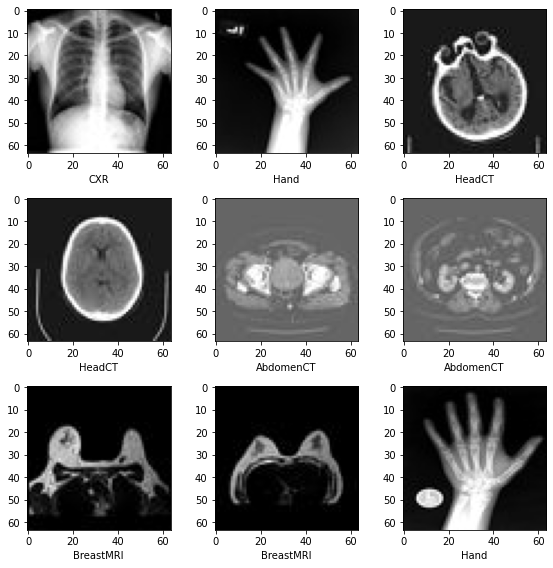

In [5]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = imread(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

As you see, the images are 64x64x1. For the sake of experimentation, we will add 2 channels with random gaussian noise to create a multi-channel images. In addition, in the followin, we have provided the list of *hand-crafted* features including basic statistical featurs as well as glcm features

In [6]:
from skimage.util import random_noise

def add_two_noise_channels(im):
    image = np.asarray(im)/255.
    random_noise_1 = random_noise(image*0.0)
    random_noise_2 = random_noise(image*0.0)
    image_RGB = np.stack([image, random_noise_1, random_noise_2], axis = 2)
    image_RGB = image_RGB*255.
    return image_RGB.astype(np.uint8)


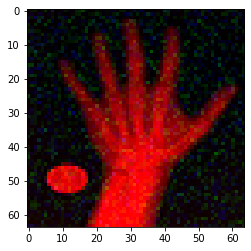

In [7]:
plt.imshow(add_two_noise_channels(im))

as we see, we only have information in the Red channel, but green & blue are only noise.

In [8]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.spatial import distance as dist
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy




def basic_statistical_features(image):
    """calculates the set of basic statistical features 
    
    Calculates the standard statistical features per channel every 10th percentile,
    sum of the pixel values and different moments

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels.

    Returns
    -------
    features :  dict  
        dictionary including percentiles, moments and sum per channel 

    """
    # storing the feature values
    features = dict()
    for ch in range(image.shape[2]):
        # percentiles
        features["min_intensity_Ch" + str(ch+1)] = image[:,:,ch].min()
        features["percentile10_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.1)
        features["percentile20_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.2)
        features["percentile30_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.3)
        features["percentile40_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.4)
        features["percentile50_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.5)
        features["percentile60_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.6)
        features["percentile70_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.7)
        features["percentile80_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.8)
        features["percentile90_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 0.9)
        features["max_intensity_Ch" + str(ch+1)] = image[:,:,ch].max()

        # pixel sum
        features["total_intensity_Ch" + str(ch+1)] = image[:,:,ch].sum()

        # moments
        features["mean_intensity_Ch" + str(ch+1)] = image[:,:,ch].mean()
        features["std_intensity_Ch" + str(ch+1)] = image[:,:,ch].std()
        features["kurtosis_intensity_Ch" + str(ch+1)] = kurtosis(image[:,:,ch].ravel()) 
        features["skew_intensity_Ch" + str(ch+1)] = skew(image[:,:,ch].ravel()) 

        features["shannon_entropy_Ch" + str(ch+1)] = shannon_entropy(image[:,:,ch])
    
    return features




def glcm_features(image):
    """calculates the glcm features 
    
    Calculates the features per channel using glcm features including
    contrast, dissimilarity, homogeneity, ASM, energy and correlation.
    For more info please refer to:
    https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels. 

    Returns
    -------
    features :  dict  
        dictionary including 'contrast_Chx', 'dissimilarity_Chx', 'homogeneity_Chx'
        'ASM_Chx', 'energy_Chx' and 'correlation_Chx' per channel where 
        x will be substituted by the channel number starting from 1. 

    """
    features = dict()
    for ch in range(image.shape[2]):
        # create a 2D temp image 
        temp_image = image[:,:,ch].copy()
        temp_image = (temp_image/temp_image.max())*255 # use 8bit pixel values for GLCM
        temp_image = temp_image.astype('uint8') # convert to unsigned for GLCM

        # calculating glcm
        glcm = greycomatrix(temp_image,distances=[5],angles=[0],levels=256)

        # storing the glcm values
        features["contrast_Ch" + str(ch+1)] = greycoprops(glcm, prop='contrast')[0,0]
        features["dissimilarity_Ch" + str(ch+1)] = greycoprops(glcm, prop='dissimilarity')[0,0]
        features["homogeneity_Ch" + str(ch+1)] = greycoprops(glcm, prop='homogeneity')[0,0]
        features["ASM_Ch" + str(ch+1)] = greycoprops(glcm, prop='ASM')[0,0]
        features["energy_Ch" + str(ch+1)] = greycoprops(glcm, prop='energy')[0,0]
        features["correlation_Ch" + str(ch+1)] = greycoprops(glcm, prop='correlation')[0,0]

    return features




In this case, the feature vectore would be 23x3 = 69 features.

In [9]:

image = imread(image_file_list[0])
image = add_two_noise_channels(image)/255.
features = dict()
features.update(basic_statistical_features(image))
features.update(glcm_features(image)) 


df_features = pd.DataFrame(columns=features,index = range(len(image_file_list)))


In [ ]:
for i in tqdm(range(len(image_file_list))):
    image = imread(image_file_list[i])
    image = add_two_noise_channels(image)/255.
    features = dict()
    features.update(basic_statistical_features(image))
    features.update(glcm_features(image)) 
    df_features.loc[i, :] = features

100%|█████████▉| 11949/12000 [03:43<00:00, 53.46it/s]

Now lets split the data to train and test, preprocess it and finally, use a Random Forest classifier

In [ ]:
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#
X = df_features.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, image_label_list, test_size=0.25)

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_test = norm.transform(X_test)



In [ ]:
model = RandomForestClassifier()
# fit the model
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

As you see, the quality of the prediction is pretty good. Now let's take a look at the top 20 important features

In [ ]:
# get importance
importances = model.feature_importances_
    
indices = np.argsort(importances)[-20:-1]

plt.title('Feature Importances (train set)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [df_features.columns.values[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Expectedly, we only see *Ch1* as part of the important features. Also, we see there is a drop around 0.01 of relative importance. Now Let's take a look at the distribution of importance of features per channel. We use 0.01 as our threshold for relative importance

In [ ]:
channels = ["Ch1",  "Ch2","Ch3"]
threshold = 0.01
channel_importances = []
for ch in channels:
    channel_importances.append([y for x,y in zip(df_features.columns, model.feature_importances_) if ch in x and  y > threshold])


In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Channel Importance')
ax = fig.add_subplot(111)
plt.boxplot(channel_importances)
ax.set_xticklabels(channels)
plt.show()

Again we see that Ch1 is the most important channel. We can also repeat the same experiment using permutation importance. Considering that random forest importances are based on train set, it might be biased. therefore we calculate the feature importances based on the train set

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()[-20:-1]

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=[df_features.columns.values[i] for i in indices])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()